In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(card.shape)
display(card.head(3))

print(user.shape)
display(user.head(3))

print(sub.shape)
display(sub.head(3))

(471283, 12)


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction


(457958, 11)


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction


(416, 10)


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011


(97, 17)


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4


(457958, 2)


,0,1
0,471283,0
1,471284,1
2,471285,0


In [5]:
print(f"number of train miss values : {train.isnull().sum().sum()}")
print(f"number of test miss values : {test.isnull().sum().sum()}")
print(f"number of card miss values : {card.isnull().sum().sum()}")
print(f"number of user miss values : {user.isnull().sum().sum()}")

number of train miss values : 149908
number of test miss values : 147412
number of card miss values : 0
number of user miss values : 0


In [6]:
train.isnull().sum()

index                 0
user_id               0
card_id               0
amount                0
errors?               0
is_fraud?             0
merchant_id           0
merchant_city         0
merchant_state    70688
zip               79220
mcc                   0
use_chip              0
dtype: int64

0    438652
1     32631
Name: is_fraud?, dtype: int64


<Axes: >

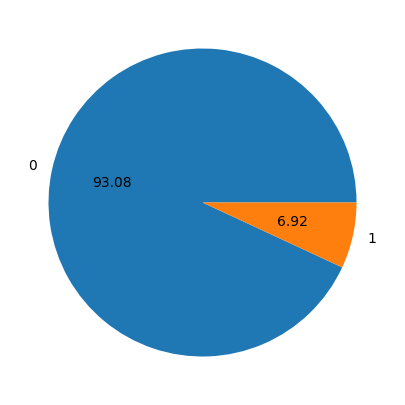

In [7]:
print(train["is_fraud?"].value_counts())

fig, ax = plt.subplots(figsize=[8, 5])
train.groupby("is_fraud?").size().plot(kind="pie", autopct="%.2f", ax=ax)

In [8]:
print(f"number of train user id {train.user_id.nunique()}")
print(f"number of test user id {test.user_id.nunique()}")

number of train user id 97
number of test user id 97


In [9]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing

In [10]:
train["amount"] = train["amount"].astype(str).str.extract("(\d+)").astype("float32")
test["amount"] = test["amount"].astype(str).str.extract("(\d+)").astype("float32")

In [11]:
train = train.fillna("NAN")
test = test.fillna("NAN")

train_city_c = train["merchant_city"].value_counts().to_dict()
test_city_c = test["merchant_city"].value_counts().to_dict()
train_state_c = train["merchant_state"].value_counts().to_dict()
test_state_c = test["merchant_state"].value_counts().to_dict()

train["city_c"] = train["merchant_city"].map(lambda x: train_city_c[x]).values
test["city_c"] = test["merchant_city"].map(lambda x: test_city_c[x]).values
train["state_c"] = train["merchant_state"].map(lambda x: train_state_c[x]).values
test["state_c"] = test["merchant_state"].map(lambda x: test_state_c[x]).values

train.loc[train["city_c"]<20, "merchant_city"] = "small_city"
test.loc[test["city_c"]<20, "merchant_city"] = "small_city"
train.loc[train["state_c"]<20, "merchant_state"] = "small_state"
test.loc[test["state_c"]<20, "merchant_state"] = "small_state"

In [12]:
concat_data = pd.concat([train,test],axis=0)
for col in ["errors?", "merchant_city", "merchant_state", "use_chip"]:
  print(col)
  le = preprocessing.LabelEncoder()
  le.fit(concat_data[col])
  concat_data[col] = le.transform(concat_data[col])

train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

errors?
merchant_city
merchant_state
use_chip


In [13]:
numerical_features = ["amount"]
categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip"]
target = "is_fraud?"

In [14]:
class CFG:
  ver=1
  model="lightgbm"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target="is_fraud?"
  boosting_type="gbdt"

In [15]:
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_df, train_df[CFG.target])):
    train_df.loc[valid_index, "fold"] = fold
train_df['fold'] = train_df['fold'].astype(int)
display(train_df.groupby('fold').size())

fold
0    94257
1    94257
2    94257
3    94256
4    94256
dtype: int64

In [16]:
params = {
        'objective': 'binary',
        #'metric': 'logloss',
        'learning_rate': 0.05,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.1,
        "n_estimators":1000,
    }

orig_features = numerical_features + categorical_features
oof_df = pd.DataFrame()
test_preds = np.zeros(len(test_df))

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_X = train_folds[orig_features]
    valid_X = valid_folds[orig_features]
    test_X = test_df[orig_features]
    train_labels = train_folds[CFG.target].values
    valid_labels = valid_folds[CFG.target].values

    model = lgb.LGBMClassifier(**params)
    model.fit(train_X, train_labels,
            eval_set=[(valid_X, valid_labels)],
            #eval_metric="rmse",
            verbose = 200,
            categorical_feature=categorical_features,
            early_stopping_rounds=50)

    valid_folds["pred"] = model.predict_proba(valid_X)[:, 1]
    test_preds += model.predict_proba(test_X)[:, 1]
    oof_df = pd.concat([oof_df, valid_folds])

    validy_pred = np.where(valid_folds["pred"]>0.5, 1, 0)
    scoref1 =  f1_score(valid_labels, validy_pred)
    scoreacc = accuracy_score(valid_labels, validy_pred)
    print(f"F1 Score : {scoref1}")

===============  FOLD : 0  ===============


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New cate

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	valid_0's binary_logloss: 0.139126
[400]	valid_0's binary_logloss: 0.135191
F1 Score : 0.6239389604196471
===============  FOLD : 1  ===============
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New cate

[200]	valid_0's binary_logloss: 0.139534
[400]	valid_0's binary_logloss: 0.135797
[600]	valid_0's binary_logloss: 0.134661
[800]	valid_0's binary_logloss: 0.13381
[1000]	valid_0's binary_logloss: 0.133566
F1 Score : 0.6331411286511012
===============  FOLD : 2  ===============
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New cate

[200]	valid_0's binary_logloss: 0.138251
[400]	valid_0's binary_logloss: 0.134513
[600]	valid_0's binary_logloss: 0.133668
F1 Score : 0.6265037415932557
===============  FOLD : 3  ===============
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New cate

[200]	valid_0's binary_logloss: 0.139645
[400]	valid_0's binary_logloss: 0.135609
[600]	valid_0's binary_logloss: 0.13418
[800]	valid_0's binary_logloss: 0.133886
F1 Score : 0.6364576478330356
===============  FOLD : 4  ===============


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New cate

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	valid_0's binary_logloss: 0.141502
[400]	valid_0's binary_logloss: 0.137117
[600]	valid_0's binary_logloss: 0.135669
[800]	valid_0's binary_logloss: 0.135118
[1000]	valid_0's binary_logloss: 0.134753
F1 Score : 0.6292348686714884


In [17]:
f1score =  f1_score(oof_df[CFG.target], np.where(oof_df["pred"]>0.5,1,0))
print(f'CV F1 Score: {f1score}')

CV F1 Score: 0.6298752984876624


In [18]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.2, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oof_df[CFG.target], (oof_df["pred"]>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oof_df[CFG.target], (oof_df["pred"]>best_thresh).astype(int))))

F1 score at threshold 0.2 is 0.6209382084520141
F1 score at threshold 0.21 is 0.6240044917921364
F1 score at threshold 0.22 is 0.6278014780989005
F1 score at threshold 0.23 is 0.6310287551620621
F1 score at threshold 0.24 is 0.6344129179659762
F1 score at threshold 0.25 is 0.6366323163771129
F1 score at threshold 0.26 is 0.6387355030615636
F1 score at threshold 0.27 is 0.6402175651895696
F1 score at threshold 0.28 is 0.6419249987871731
F1 score at threshold 0.29 is 0.6428921809084667
F1 score at threshold 0.3 is 0.6436770219161341
F1 score at threshold 0.31 is 0.6445674648169146
F1 score at threshold 0.32 is 0.6453110804535819
F1 score at threshold 0.33 is 0.6459182287421896
F1 score at threshold 0.34 is 0.6460120913185702
F1 score at threshold 0.35 is 0.6459045842401631
F1 score at threshold 0.36 is 0.6456657263260543
F1 score at threshold 0.37 is 0.6455525370256769
F1 score at threshold 0.38 is 0.6448106715601511
F1 score at threshold 0.39 is 0.6440280614510258
F1 score at threshold 

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


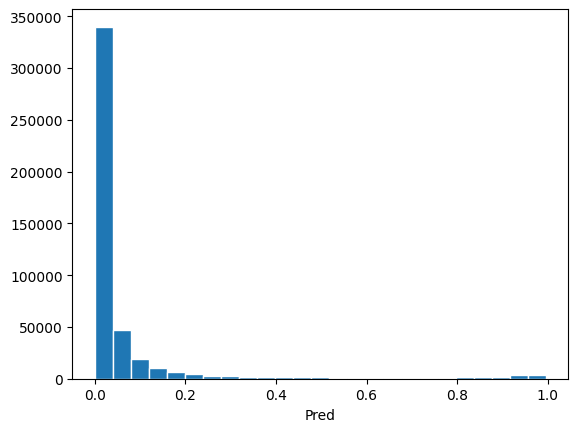

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


In [19]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_preds / CFG.n_folds
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)